In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import time
import copy

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data as D

import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms

In [3]:
# JUPYTER_CMS is used to import the code from other notebooks
from jupyter_cms.loader import load_notebook
pp = load_notebook('./data_preprocessing.ipynb')

In [4]:
path = '../airbus/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Vizualization

tensor([1, 0, 0, 1, 1, 1, 1, 0])


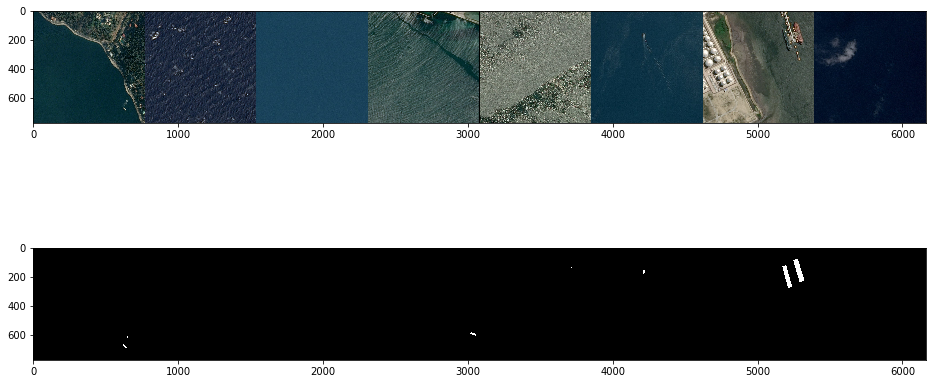

In [5]:
airimg = pp.AirbusDS(path, aug=True, resize_factor=1, empty_frac=0.3, test_size=0.1)
airimg_train, airimg_val = airimg.get_ds()
# Use the torch dataloader to iterate through the dataset
trainloader = D.DataLoader(airimg_train, batch_size=8, shuffle=True, num_workers=0)

dataiter = iter(trainloader)
images, masks, labels = dataiter.next()

# show images
plt.figure(figsize=(16,8))
plt.subplot(211)
pp.imshow(torchvision.utils.make_grid(images))
plt.subplot(212)
pp.imshow(torchvision.utils.make_grid(masks))
print(labels)

# Simple classification model

In [6]:
# ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*45*45, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*45*45)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
net = net.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model

In [8]:
airimg = pp.AirbusDS(path, aug=True, resize_factor=4, empty_frac=0.3, test_size=0.1)
airimg_train, airimg_val = airimg.get_ds()
# Use the torch dataloader to iterate through the dataset
trainloader = D.DataLoader(airimg_train, batch_size=128, shuffle=True, num_workers=0)

start_time = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, masks, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2 == 1:    # print every ... mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0

print('Finished Training')
run_time = int(time.time() - start_time)
print('The training took: ', run_time, ' sec.')

[1,     2] loss: 0.701
[1,     4] loss: 0.709
[1,     6] loss: 0.703
[1,     8] loss: 0.706
[1,    10] loss: 0.705
[1,    12] loss: 0.703
[1,    14] loss: 0.701
[1,    16] loss: 0.698
[1,    18] loss: 0.693
[1,    20] loss: 0.698
[1,    22] loss: 0.696
[1,    24] loss: 0.696
[1,    26] loss: 0.694
[1,    28] loss: 0.693
[1,    30] loss: 0.693
[1,    32] loss: 0.690


IndexError: tuple index out of range

In [ ]:
# Save the model
torch.save(net, '../cnn')

# Evaluation

In [ ]:
valloader = D.DataLoader(airimg_val, batch_size=128, shuffle=True, num_workers=0)

dataiter = iter(valloader)
images = images.to(device).float()
labels = labels.to(device).long()
images, labels = dataiter.next()

# print images
#pp.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', labels)

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(predicted)

In [ ]:
# And now on the whole validation dataset

num_val_images = len(airimg_val.filenames)
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.to(device).float()
        labels = labels.to(device).long()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (num_val_images, 100 * correct / total))

In [ ]:
time.time()

In [ ]:
torch.cuda.is_available()